In [11]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import pydicom
import nibabel as nib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, clear_output

import math
import os
import os.path
import scipy as sp
import scipy.ndimage

from fcmeans import FCM

from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans

from skimage import segmentation, measure

from numpy.fft import fft2, ifft2, fftshift, ifftshift


In [2]:
def plot_images(img_stack, *, labels=None, figdim=5, colormap=plt.cm.gray, **imshowkwarg):
    """
    Funzione di utilità per mostrare una grigli di immagini, impostando la lista delle legende
    e, opzionalmente, la colormap che di default è impostata a livelli di grigio
    """    
    nimag = len(img_stack)

    # creiamo il layout
    nrows = 1 if nimag <= 3 else 2 if nimag <= 6 else 3 if nimag <=12 else 4 if nimag <= 16 else 5
    ncols = nimag if nrows == 1 else 2 if nimag == 4 else 3 if nimag <=9 else 4 if nimag <= 16 else 5

    # generiamo la figura con un canvas ce riserva 5x5 pollici a immagine
    # e i riferimenti alle singole immagini
    fig, axs = plt.subplots(nrows,ncols,squeeze=False,figsize=(figdim*ncols, figdim*nrows))
    
    img = 0 # contatore delle immagini

    for r in range(nrows):
        for c in range(ncols):
            # eliminiamo lo stile del grafico
            axs[r, c].tick_params(axis='both',\
                    which='both',\
                    bottom=False,top=False,right=False,left=False,\
                    labelbottom=False,labelleft=False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # se ci troviamo nella posizione di una
            # immagine allora la mostriamo
            if r*ncols + c < nimag:
                if labels != None:
                    axs[r, c].set_title(labels[img])
            
                axs[r, c].imshow(img_stack[img], cmap=colormap, **imshowkwarg)

                img += 1 # immagine successiva
    
    return axs

def load_dcm_volume(directory):
    """
    Funzione che carica un volume di dati DICOM da una cartella
    assumendo che questa contenga solamente un insieme di file .dcm
    """

    # leggiamo la lista dei file nella cartella
    files = os.listdir(directory)
    files.sort()
    
    # leggiamo il primo file per ottenere le dimensioni e il tipo della singola slice
    file = pydicom.dcmread(f'{directory}/{files[0]}')
    
    # creiamo il volume
    volume = np.full((len(files),file.pixel_array.shape[0],file.pixel_array.shape[1]),\
                    1,dtype=file.pixel_array.dtype)

    # carichiamo la prima slice, già letta, e successivamente le altre 
    volume[0,:,:] = file.pixel_array

    for i in range(1,len(files)):
        volume[i,:,:] = pydicom.dcmread(f'{directory}/{files[i]}').pixel_array
    
    vol = np.copy(volume)

    if file.SeriesDescription != '' and file.SeriesDescription.find('Sag') != -1:
        vol=np.reshape(vol,(volume.shape[1],volume.shape[2],volume.shape[0]))

        for i in range(volume[:,0,:].shape[1]):
            vol[i,:,:] = volume[:,i,:].T
    
    if file.SeriesDescription != '' and file.SeriesDescription.find('Cor') != -1:
        vol=np.reshape(vol,(volume.shape[1],volume.shape[0],volume.shape[2]))

        for i in range(volume[:,0,:].shape[0]):
            vol[i,:,:] = volume[:,i,:]
    
    return vol


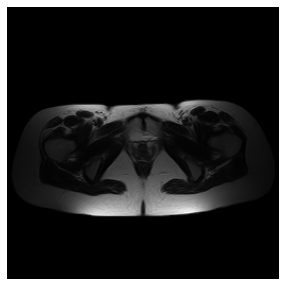

In [3]:
img = pydicom.dcmread('Data/bacino.dcm')

img_data = img.pixel_array

axes = plot_images([img_data])

In [4]:
flat_data = img_data.reshape((img_data.shape[0]*img_data.shape[1],1))
fcm = FCM(n_clusters=4)
fcm.fit(flat_data)
fcm_labels = fcm.predict(flat_data)

In [5]:
clustered = fcm_labels.reshape((img_data.shape[0],img_data.shape[1]))

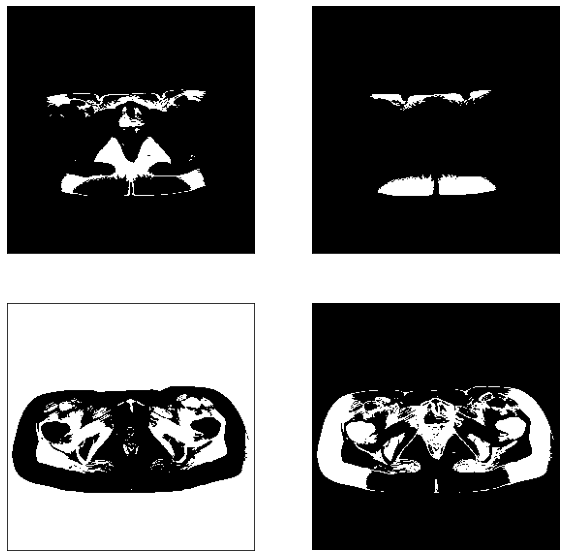

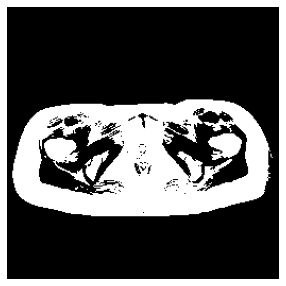

In [9]:
clusters = np.full((4,img_data.shape[0],img_data.shape[1]),0)

for i in range(4):
    clusters[i] = np.where(clustered == i, 1, 0)

mask = np.where(clusters[2] == 0, 1, 0)

axes = plot_images(clusters)
axes = plot_images([mask])

In [51]:
def butterworth(order, cutoff, coeff, shape):

    h = np.full(shape,0,dtype='float')
    
    for u in range(shape[0]//2):
        for v in range(shape[1]//2):

            d_uv = math.sqrt(u**2 + v**2)

            h[u, v] = 1 / (1 + coeff * ((d_uv/cutoff)**(2*order)) )
            h[-u, v] = h[u, -v] = h [-u, -v] = h[u, v]
    
    h = fftshift(h)

    return h

In [91]:
def freq_filt(img,kern,*kernargs,complex=False):

    h = kern(*kernargs)
    
    (padr, padc) = (img.shape[0]//2, img.shape[1]//2)

    padded_img = np.pad(img,(padr, padc))

    fft_image = fft2(padded_img)

    fft_image = fftshift(fft_image)

    fft_image.real = h * fft_image.real
    fft_image.imag = h * fft_image.imag

    fft_image = ifftshift(fft_image)

    filtered_image = ifft2(fft_image)

    if complex == True:
        return filtered_image[padr:filtered_image.shape[0] - padr,\
                               padc:filtered_image.shape[1] - padc]
    else:
        return filtered_image.real[padr:filtered_image.shape[0] - padr,\
                               padc:filtered_image.shape[1] - padc]


In [157]:
img_log = np.full(img_data.shape,0.0,dtype='float')

for i in range(img_data.shape[0]):
    for j in range(img_data.shape[1]):
        img_log[i, j] = 0 if mask[i, j] == 0 else math.log(img_data[i,j])

img_filt = freq_filt(img_log, butterworth, 1, 3, 0.414, (img_data.shape[0]*2,img_data.shape[1]*2),complex=True)

roi_filt = freq_filt(mask, butterworth, 1, 3, 0.414, (img_data.shape[0]*2,img_data.shape[1]*2),complex=True)

log_bias = np.abs(img_filt)/np.abs(roi_filt)

img_restored = np.exp(img_log - log_bias)

correction = np.max(img_data)/(np.max(img_data) - np.min(img_data))

img_restored = correction * (img_restored - np.min(img_data))

bias_restored = correction * (np.exp(log_bias) - np.min(img_data))



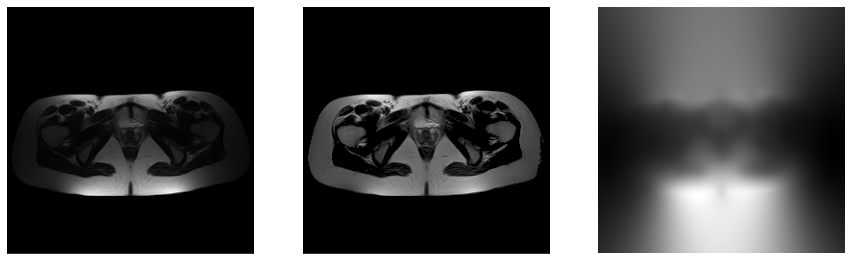

In [158]:
axes = plot_images([img_data, img_restored, bias_restored])